In [1]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as gnn
import torch_geometric.transforms
import torch_geometric.utils
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from node2vec import Node2Vec
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
torch_geometric.seed_everything(0)

IO configs

In [3]:
data_dir = Path(".").absolute().parent / "data"
models_dir = data_dir / "models"
models_dir.mkdir(exist_ok=True)

## Data loading and preprocessing
Load data

In [4]:
node2vec_embedding = pd.read_pickle(data_dir / "embeddings/node2vec_embedding.pkl")
spectral_embedding = pd.read_pickle(data_dir / "embeddings/spectral_embedding.pkl")
node_info = pd.read_pickle(data_dir / "preprocessed/node_info.pkl")
edge_info = pd.read_pickle(data_dir / "preprocessed/edge_info.pkl")

In [5]:
node2vec_embedding.head()

,node2vec_ACH_0,node2vec_ACH_1,node2vec_ACH_2,node2vec_ACH_3,node2vec_ACH_4,node2vec_ACH_5,node2vec_ACH_6,node2vec_ACH_7,node2vec_SER_0,node2vec_SER_1,...,node2vec_DA_6,node2vec_DA_7,node2vec_OCT_0,node2vec_OCT_1,node2vec_OCT_2,node2vec_OCT_3,node2vec_OCT_4,node2vec_OCT_5,node2vec_OCT_6,node2vec_OCT_7
720575940621280688,-2.191900,0.049500,-0.072872,2.529746,-0.076199,-0.797629,0.910458,2.138495,0.024376,0.049488,...,2.257592,-1.052635,-0.086376,-0.016342,-0.075253,0.132493,0.043961,-0.032677,0.089628,0.128388
720575940629174889,-1.859022,1.641020,0.985564,2.125586,-0.007060,1.693392,-0.502335,0.876726,0.076958,-1.087816,...,1.963795,-0.368879,0.061196,0.024918,0.113039,0.013703,0.092897,-0.082858,-0.096461,-0.012831
720575940637132389,-1.602327,0.615010,0.530065,1.076127,-0.032424,2.005130,-0.967994,0.755368,0.100470,-0.249987,...,1.295472,-1.272117,0.060951,0.014239,-0.058449,-0.046567,-0.092479,0.090280,0.040239,-0.106398
720575940654777505,-6.589922,-6.693934,2.004244,0.055977,-4.032084,3.622172,8.605543,3.299473,-0.115199,0.002871,...,0.115346,-0.042695,0.112006,0.021041,0.086480,0.051845,-0.034308,-0.000330,-0.061942,0.119736
720575940616159371,-6.747396,-7.012646,2.138878,0.055543,-4.097299,3.801588,8.909692,3.433254,-0.042529,0.076106,...,-0.012369,-0.027677,0.123636,0.086710,0.055061,0.047037,-0.039150,-0.109720,-0.061458,-0.098871


Merge node info (containing morphological features and target labels) with node features

In [6]:
node_info_cols = [
    "root_id", "super_class", "class", "hemilineage",
    "length_nm", "area_nm", "size_nm"
]
node_info_merged = pd.merge(
    node_info[node_info_cols].set_index("root_id"),
    node2vec_embedding,
    how="right",
    left_index=True,
    right_index=True,
)
node_info_merged = pd.merge(
    node_info_merged,
    spectral_embedding,
    how="left",
    left_index=True,
    right_index=True,
)
node_info_merged = node_info_merged.rename(
    columns={
        "length_nm": "morph_length", "area_nm": "morph_area", "size_nm": "morph_size"
    }
)

In [7]:
node_info_merged.head()

,super_class,class,hemilineage,morph_length,morph_area,morph_size,node2vec_ACH_0,node2vec_ACH_1,node2vec_ACH_2,node2vec_ACH_3,...,spectral_DA_6,spectral_DA_7,spectral_OCT_0,spectral_OCT_1,spectral_OCT_2,spectral_OCT_3,spectral_OCT_4,spectral_OCT_5,spectral_OCT_6,spectral_OCT_7
720575940621280688,central,MBIN,NaN,42474828,170716759168,11388240896000,-2.191900,0.049500,-0.072872,2.529746,...,-0.000459,-0.000101,-0.004504,0.000367,-0.000205,-0.000023,-0.000088,0.000124,-0.000062,0.000099
720575940629174889,central,MBIN,NaN,42979456,169932248320,11757734236160,-1.859022,1.641020,0.985564,2.125586,...,-0.000853,-0.000122,-0.004436,0.000358,-0.000198,-0.000022,-0.000085,0.000119,-0.000059,0.000095
720575940637132389,central,MBIN,NaN,20778086,112883269248,6248738539520,-1.602327,0.615010,0.530065,1.076127,...,-0.000359,0.000273,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092
720575940654777505,central,NaN,NaN,3049104,14418566016,1265078210560,-6.589922,-6.693934,2.004244,0.055977,...,0.000108,0.000091,-0.004404,0.000341,-0.000164,-0.000067,-0.000056,0.000115,-0.000060,0.000086
720575940616159371,central,NaN,VLPl2_medial,3678799,16298574976,1078699100160,-6.747396,-7.012646,2.138878,0.055543,...,0.000108,0.000091,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092


Preprocessing: remove minor classes, encode classes with integers, standardize feature columns.

In [8]:
class_size_thrs = {"super_class": 100, "class": 100, "hemilineage": 200}
id2name_lookups = {}
name2id_lookups = {}
for pred_target, thr in class_size_thrs.items():
    # Remove minor classes
    counts = node_info_merged[pred_target].value_counts()
    valid_classes = counts[counts >= thr].index
    mask = node_info_merged[pred_target].isin(valid_classes)
    node_info_merged.loc[~mask, pred_target] = np.nan

    # Encode classes with integers (-1 == other classes)
    id2name = dict(enumerate(valid_classes))
    name2id = {v: k for k, v in id2name.items()}
    node_info_merged[pred_target] = [
        name2id[x] if x in valid_classes else -1
        for x in node_info_merged[pred_target].values
    ]
    id2name_lookups[pred_target] = id2name
    name2id_lookups[pred_target] = name2id

# Standardize feature columns
cols_to_standardize = [
    col for col in node_info_merged.columns
    if col.split("_")[0] in ("node2vec", "spectral", "morph")
]
scaler = StandardScaler()
scaler.fit(node_info_merged[cols_to_standardize])
node_info_merged[cols_to_standardize] = scaler.transform(
    node_info_merged[cols_to_standardize]
)

In [9]:
node_info_merged.head()

,super_class,class,hemilineage,morph_length,morph_area,morph_size,node2vec_ACH_0,node2vec_ACH_1,node2vec_ACH_2,node2vec_ACH_3,...,spectral_DA_6,spectral_DA_7,spectral_OCT_0,spectral_OCT_1,spectral_OCT_2,spectral_OCT_3,spectral_OCT_4,spectral_OCT_5,spectral_OCT_6,spectral_OCT_7
720575940621280688,0,-1,-1,34.399891,38.680037,32.062323,-1.375980,0.070053,-0.098817,2.124283,...,-0.117059,-0.032241,-0.355508,0.039667,-0.030084,-0.002355,-0.014320,0.018590,-0.010154,0.015700
720575940629174889,0,-1,-1,34.819189,38.498702,33.124552,-0.928484,2.327172,1.174319,1.654374,...,-0.206240,-0.036830,-0.120393,0.037671,-0.028552,-0.002168,-0.013634,0.017523,-0.009600,0.014807
720575940637132389,0,-1,-1,16.371938,25.312181,17.287160,-0.583402,0.872068,0.626424,0.434185,...,-0.094306,0.052727,0.065077,0.036091,-0.027338,-0.002020,-0.013094,0.016680,-0.009164,0.014090
720575940654777505,0,-1,-1,1.640821,2.552669,2.960015,-7.288356,-9.493595,2.399634,-0.751927,...,0.011581,0.011346,-0.010467,0.033734,-0.020902,-0.012187,-0.007213,0.016590,-0.009796,0.012696
720575940616159371,0,-1,13,2.164038,2.987221,2.424208,-7.500051,-9.945597,2.561578,-0.752432,...,0.011581,0.011346,0.065077,0.036091,-0.027338,-0.002020,-0.013094,0.016680,-0.009164,0.014090


Percentages of neurons with valid labels in each classification task:

In [10]:
print(
    (node_info_merged["super_class"] != -1).sum() / len(node_info_merged),
    (node_info_merged["class"] != -1).sum() / len(node_info_merged),
    (node_info_merged["hemilineage"] != -1).sum() / len(node_info_merged),
)

0.9986577181208054 0.4021009629413481 0.25262134033654315


Split train/val/test sets

In [11]:
trainval_df, test_df = train_test_split(
    node_info_merged, test_size=0.2, random_state=0
)
train_df, val_df = train_test_split(
    trainval_df, test_size=0.25, random_state=0
)
split_dfs = {
    "train": train_df, "val": val_df, "test": test_df
}

## Non-GNN baselines
Logistic regression

In [12]:
_columns_all = list(node_info_merged.columns)
feature_columns = {
    "node2vec": [
        col for col in _columns_all
        if col.split("_")[0] in ("morph", "node2vec")
    ],
    "spectral": [
        col for col in _columns_all
        if col.split("_")[0] in ("morph", "spectral")
    ],
    "both": [
        col for col in _columns_all
        if col.split("_")[0] in ("morph", "node2vec", "spectral")
    ]
}

In [13]:
results_all = []
for pred_target in ["super_class", "class", "hemilineage"]:
    for features_group in ["node2vec", "spectral", "both"]:
        # Fetch x, y
        x_cols = feature_columns[features_group]
        train_x = train_df[x_cols]
        train_y = train_df[pred_target]
        train_x = train_x[train_y != -1]
        train_y = train_y[train_y != -1]
        val_x = val_df[x_cols]
        val_y = val_df[pred_target]
        val_x = val_x[val_y != -1]
        val_y = val_y[val_y != -1]
        assert train_x.shape[1] == val_x.shape[1] == len(x_cols)

        # Train and evaluate models
        models = {
            "lr": LogisticRegression(max_iter=1000, random_state=0),
            "mlp": MLPClassifier(
                hidden_layer_sizes=[16, 16], max_iter=1000, random_state=0
            ),
        }
        for model_name, model in models.items():
            model.fit(train_x, train_y)
            with open(
                models_dir / f"{model_name}_{pred_target}_{features_group}.pkl", "wb"
            ) as f:
                pickle.dump(model, f)
            val_pred = model.predict(val_x)
            acc = accuracy_score(val_y, val_pred)
            f1 = f1_score(val_y, val_pred, average='macro')
            results_all.append([model_name, pred_target, features_group, acc, f1])
            print(
                f"{model_name} - Predicting {pred_target} from {features_group} "
                f"features: acc={acc:.4f}, f1={f1:.4f}"
            )

lr - Predicting super_class from node2vec features: acc=0.8260, f1=0.5322
mlp - Predicting super_class from node2vec features: acc=0.8921, f1=0.5781
lr - Predicting super_class from spectral features: acc=0.7602, f1=0.3824
mlp - Predicting super_class from spectral features: acc=0.8485, f1=0.4908
lr - Predicting super_class from both features: acc=0.8454, f1=0.5764
mlp - Predicting super_class from both features: acc=0.9019, f1=0.6038
lr - Predicting class from node2vec features: acc=0.8982, f1=0.8340
mlp - Predicting class from node2vec features: acc=0.9195, f1=0.8425
lr - Predicting class from spectral features: acc=0.7307, f1=0.5701
mlp - Predicting class from spectral features: acc=0.8896, f1=0.7767
lr - Predicting class from both features: acc=0.9066, f1=0.8489
mlp - Predicting class from both features: acc=0.9185, f1=0.8419
lr - Predicting hemilineage from node2vec features: acc=0.4785, f1=0.5476
mlp - Predicting hemilineage from node2vec features: acc=0.4808, f1=0.5502
lr - Pred

In [14]:
# results_all_df = pd.DataFrame(
#     results_all, columns=["model", "pred_target", "feature_group", "accuracy", "f1"]
# )
# results_all_df

In [15]:
# results_all_df.to_pickle("../data/classification_stats.pkl")

## GNN models

### Build PyG graph object

Build NetworkX graph

In [16]:
edge_info = edge_info[
    edge_info["pre_root_id"].isin(node_info_merged.index)
    & edge_info["post_root_id"].isin(node_info_merged.index)
]
edge_info.head()

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940619238582,720575940634854554,AVLP_R,35,ACH
1,720575940634034839,720575940660217473,AL_R,38,SER
2,720575940612615570,720575940604789676,EB,26,GABA
3,720575940614901215,720575940626983952,PRW,70,GABA
4,720575940627312104,720575940625498512,SMP_R,28,GLUT


In [17]:
nx_graph = nx.from_pandas_edgelist(
    edge_info, source="pre_root_id", target="post_root_id", create_using=nx.DiGraph
)
node_info_merged_w_mask = node_info_merged.copy()
node_info_merged_w_mask["train_mask"] = (
    node_info_merged_w_mask.index.isin(train_df.index)
)
node_info_merged_w_mask["val_mask"] = (
    node_info_merged_w_mask.index.isin(val_df.index)
)
node_info_merged_w_mask["test_mask"] = (
    node_info_merged_w_mask.index.isin(test_df.index)
)
nx.set_node_attributes(nx_graph, node_info_merged_w_mask.to_dict(orient="index")) 

Define node features to be grouped and masks to select them

In [18]:
num_dims_per_nt = 8
nt_types = ["ACH", "GABA", "GLUT", "SER", "DA", "OCT"]

all_features = (
    [f"node2vec_{nt}_{i}" for nt in nt_types for i in range(num_dims_per_nt)]
    + [f"spectral_{nt}_{i}" for nt in nt_types for i in range(num_dims_per_nt)]
    + ["morph_length", "morph_area", "morph_size"]
)
node2vec_mask = np.array(
    [col.split("_")[0] in ("node2vec", "morph") for col in all_features]
)
spectral_mask = np.array(
    [col.split("_")[0] in ("spectral", "morph") for col in all_features]
)
both_mask = np.ones(len(all_features), dtype="bool")

Build PyG graph

In [19]:
pg_graph = torch_geometric.utils.from_networkx(
    nx_graph, group_node_attrs=all_features
)

In [20]:
pg_graph

Data(edge_index=[2, 1090673], super_class=[49339], class=[49339], hemilineage=[49339], train_mask=[49339], val_mask=[49339], test_mask=[49339], x=[49339, 99])

### Train GCN

In [21]:
class MyGCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, features_mask):
        super(MyGCN, self).__init__()
        self.features_mask = features_mask
        self.conv1 = gnn.GCNConv(in_dim, hidden_dim)
        self.conv2 = gnn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = gnn.GCNConv(hidden_dim, out_dim)
    
    def forward(self, data):
        x = data.x[:, features_mask]
        x = self.conv1(x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        x = F.relu(x)
        x = self.conv3(x, data.edge_index)
        return x

In [22]:
def train(
    model, graph, optimizer, criterion, num_epochs, target_col, device, verbose=False
):
    training_hist = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_acc": [],
        "val_f1": [],
    }
    
    # We exclude rows without a valid target label. The exact rows to exclude
    # depends on the target column, and therefore is decided here
    train_mask = graph.train_mask & (graph[target_col] != -1)
    val_mask = graph.val_mask & (graph[target_col] != -1)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[train_mask], graph[target_col][train_mask])
        loss.backward()
        optimizer.step()

        # Logging
        if epoch % 10 == 0:
            train_acc, train_f1 = get_scores(model, graph, train_mask, target_col)
            val_acc, val_f1 = get_scores(model, graph, val_mask, target_col)
            training_hist["epoch"].append(epoch)
            training_hist["train_loss"].append(loss.item())
            training_hist["train_acc"].append(train_acc)
            training_hist["train_f1"].append(train_f1)
            training_hist["val_acc"].append(val_acc)
            training_hist["val_f1"].append(val_f1)
            if epoch % 100 == 0 and verbose:
                print(
                    f"Epoch {epoch} | Train loss {loss.item():.4f} | "
                    f"Train acc {train_acc:.4f} | Train F1 {train_f1:.4f} | "
                    f"Val acc {val_acc:.4f} | Val F1 {val_f1:.4f}"
                )
    return pd.DataFrame.from_dict(training_hist)

def get_scores(model, graph, mask, target_col):
    model.eval()
    pred = model(graph)[mask].argmax(dim=1).cpu().detach().numpy()
    label = graph[target_col][mask].cpu().detach().numpy()
    acc = accuracy_score(label, pred)
    f1 = f1_score(label, pred, average='macro')
    return acc, f1

In [23]:
def visualize_training_history(training_hist):
    fig, axs = plt.subplots(1, 2, figsize=(5, 2), tight_layout=True)
    axs[0].plot(training_hist["epoch"], training_hist["train_loss"])
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Training loss")
    axs[1].plot(training_hist["epoch"], training_hist["train_f1"], label="Training")
    axs[1].plot(training_hist["epoch"], training_hist["val_f1"], label="Validation")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("F1 score")
    axs[1].set_ylim([0, 1])
    axs[1].legend(loc="lower right")
    sns.despine(fig=fig)

Epoch 0 | Train loss 2.7651 | Train acc 0.1178 | Train F1 0.0394 | Val acc 0.1125 | Val F1 0.0374
Epoch 100 | Train loss 0.5003 | Train acc 0.8531 | Train F1 0.6753 | Val acc 0.8401 | Val F1 0.6637
Epoch 200 | Train loss 0.2962 | Train acc 0.9075 | Train F1 0.8055 | Val acc 0.8830 | Val F1 0.7740
Epoch 300 | Train loss 0.2315 | Train acc 0.9273 | Train F1 0.8445 | Val acc 0.8925 | Val F1 0.7940
Epoch 400 | Train loss 0.1982 | Train acc 0.9354 | Train F1 0.8632 | Val acc 0.8944 | Val F1 0.8048
Epoch 500 | Train loss 0.1791 | Train acc 0.9407 | Train F1 0.8782 | Val acc 0.9018 | Val F1 0.8256
Epoch 600 | Train loss 0.1649 | Train acc 0.9453 | Train F1 0.8800 | Val acc 0.8983 | Val F1 0.8178
Epoch 700 | Train loss 0.1528 | Train acc 0.9493 | Train F1 0.8922 | Val acc 0.9028 | Val F1 0.8292
Epoch 800 | Train loss 0.1450 | Train acc 0.9514 | Train F1 0.8994 | Val acc 0.9060 | Val F1 0.8398
Epoch 900 | Train loss 0.1381 | Train acc 0.9537 | Train F1 0.9034 | Val acc 0.9084 | Val F1 0.8431
Ep

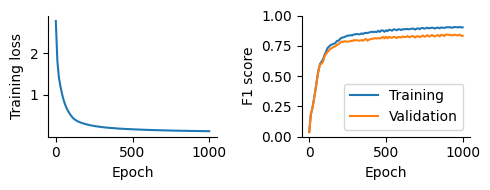

In [24]:
pred_target = "class"
features_group, features_mask = "node2vec", node2vec_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available()

gcn_model = MyGCN(
    in_dim=features_mask.sum(),
    hidden_dim=16,
    out_dim=len(id2name_lookups[pred_target]),
    features_mask=features_mask
).to(device)

optimizer = optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

training_hist = train(
    gcn_model,
    pg_graph.to(device),
    optimizer,
    criterion,
    1000 + 1,
    pred_target,
    device,
    verbose=True
)

visualize_training_history(training_hist)

===== Training model to predict super_class from node2vec features =====
GCN - Predicting super_class from node2vec features: acc=0.8921, f1=0.5825


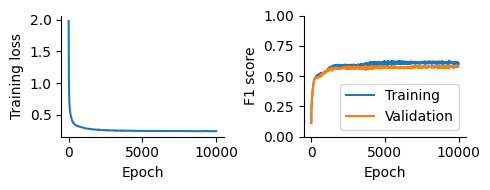

===== Training model to predict super_class from spectral features =====
GCN - Predicting super_class from spectral features: acc=0.8937, f1=0.6083


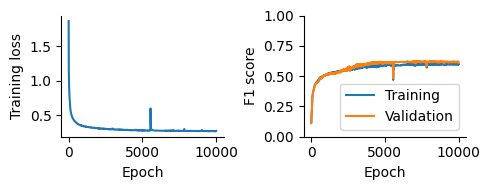

===== Training model to predict super_class from both features =====
GCN - Predicting super_class from both features: acc=0.9000, f1=0.6591


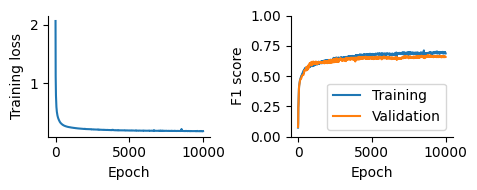

===== Training model to predict class from node2vec features =====
GCN - Predicting class from node2vec features: acc=0.8941, f1=0.8147


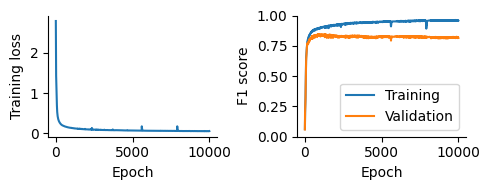

===== Training model to predict class from spectral features =====
GCN - Predicting class from spectral features: acc=0.9216, f1=0.8535


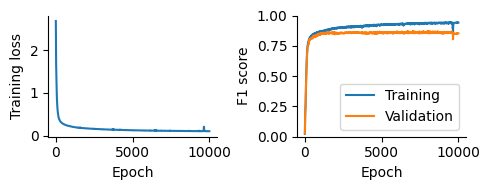

===== Training model to predict class from both features =====
GCN - Predicting class from both features: acc=0.9105, f1=0.8297


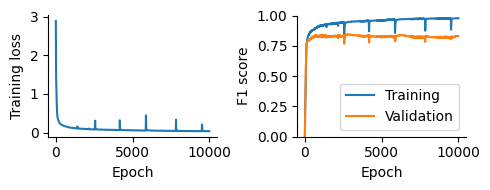

===== Training model to predict hemilineage from node2vec features =====
GCN - Predicting hemilineage from node2vec features: acc=0.5269, f1=0.5801


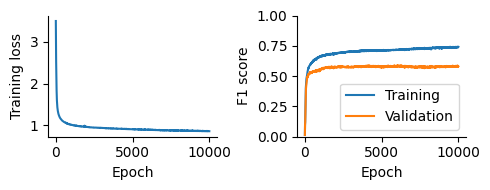

===== Training model to predict hemilineage from spectral features =====
GCN - Predicting hemilineage from spectral features: acc=0.5196, f1=0.5748


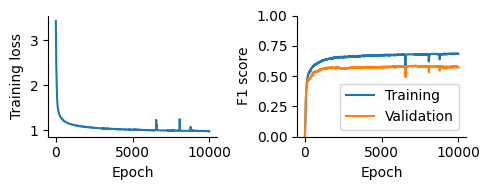

===== Training model to predict hemilineage from both features =====
GCN - Predicting hemilineage from both features: acc=0.5467, f1=0.6000


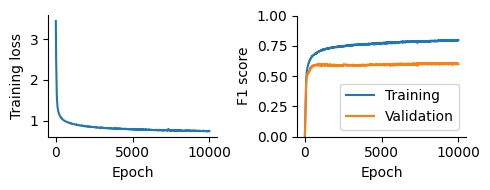

In [25]:
feature_mask_lookup = {
    "node2vec": node2vec_mask, "spectral": spectral_mask, "both": both_mask
}

for pred_target in ["super_class", "class", "hemilineage"]:
    for features_group, features_mask in feature_mask_lookup.items():
        print(
            f"===== Training model to predict {pred_target} "
            f"from {features_group} features ====="
        )
        gcn_model = MyGCN(
            in_dim=features_mask.sum(),
            hidden_dim=16,
            out_dim=len(id2name_lookups[pred_target]),
            features_mask=features_mask
        ).to(device)
        
        optimizer = optim.Adam(gcn_model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()
        
        training_hist = train(
            gcn_model,
            pg_graph.to(device),
            optimizer,
            criterion,
            10000 + 1,
            pred_target,
            device,
            verbose=False
        )

        torch.save(
            gcn_model.state_dict(),
            models_dir / f"gcn_{pred_target}_{features_group}.pth",
        )
        acc = training_hist.iloc[-1]["val_acc"]
        f1 = training_hist.iloc[-1]["val_f1"]
        results_all.append(["gcn", pred_target, features_group, acc, f1])
        print(
            f"GCN - Predicting {pred_target} from {features_group} "
            f"features: acc={acc:.4f}, f1={f1:.4f}"
        )
        visualize_training_history(training_hist)
        plt.show()

In [26]:
results_all_df = pd.DataFrame(
    results_all, columns=["model", "pred_target", "feature_group", "accuracy", "f1"]
)
results_all_df

,model,pred_target,feature_group,accuracy,f1
0,lr,super_class,node2vec,0.826011,0.532225
1,mlp,super_class,node2vec,0.892060,0.578130
2,lr,super_class,spectral,0.760156,0.382442
3,mlp,super_class,spectral,0.848514,0.490799
4,lr,super_class,both,0.845397,0.576415
5,mlp,super_class,both,0.901900,0.603827
6,lr,class,node2vec,0.898179,0.834041
7,mlp,class,node2vec,0.919502,0.842513
8,lr,class,spectral,0.730714,0.570062
9,mlp,class,spectral,0.889554,0.776716


In [27]:
results_all_df.to_csv(models_dir / "classification_stats.csv", index=False)